# PADS 2025.1 - Financial Analytics - Projeto Intermediário
**Grupo 4 - Eric Buonpater, Raphael Bomeisel, Raphael Blekic, Arthur Campedelli, Felipe Castelar**
_________

## 1. Importando bibliotecas utiilizadas

In [ ]:
#!pip install kagglehub
#!pip install statsforecast
#!pip install scikit-learn
#!pip install darts
#!pip install prophet


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached numba-0.59.1-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
  Using cached llvmlite-0.42.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached llvmlite-0.42.0-cp311-cp311-win_amd64.whl (28.1 MB)
Using cached numba-0.59.1-cp311-cp311-win_amd64.whl (2.6 MB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.45.1
    Uninstalling llvmlite-0.45.1:
      Successfully uninstalled llvmlite-0.45.1
  Attempting uninstall: numba
    Found existing installation: numba 0.62.1
    Uninstalling numba-0.62.1:
      Successfully uninstalled numba-0.62.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.9 kB 131.3 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.9 kB 219.4 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/60.9 kB 262.6 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 249.7 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
  Using cached numba-0.62.1-cp311-cp311-win_amd64.whl.metadata (2.9 kB)
  Using cached llvmlite-0.45.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/13.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.1 MB 3.5 MB/s eta 0:00:04
   - ---------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsforecast 2.0.3 requires llvmlite<0.43.0,>=0.41.0; sys_platform == "win32" and python_version >= "3.10" and python_version < "3.12", but you have llvmlite 0.45.1 which is incompatible.
statsforecast 2.0.3 requires numba<0.60.0,>=0.58.0; sys_platform == "win32" and python_version >= "3.10" and python_version < "3.12", but you have numba 0.62.1 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.metrics import mean_squared_error
import os
import kagglehub
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
from statsforecast import StatsForecast

## 2. Importando os dados utilizados

In [75]:
# Download latest version
path = kagglehub.dataset_download("yousefmoterassed/brazil-importexport-data-from-1996-to-2023")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ericl\.cache\kagglehub\datasets\yousefmoterassed\brazil-importexport-data-from-1996-to-2023\versions\2


## 3. Tratamentos iniciais dos dados

Abaixo será importado os dados. Algumas colunas serão filtradas e o código do país será adicionado em uma coluna extra.

In [76]:
# Carregar o arquivo BRAZIL_EXP_COMPLETE.CSV em um dataframe pandas
file_path = os.path.join(path, 'BRAZIL_EXP_COMPLETE.CSV')
df = pd.read_csv(file_path,sep=';')

# Remover colunas CO_NCM, CO_UNID, CO_URF, QT_ESTAT,
df = df.drop(columns=['CO_NCM', 'CO_UNID', 'CO_URF', 'QT_ESTAT'])

# Adiciona uma coluna com data utilizando as colunas CO_MES e CO_ANO
df['DATA'] = pd.to_datetime(dict(day=1, month=df['CO_MES'], year=df['CO_ANO'] ))

# Mostrar as primeiras linhas do dataframe
df.head()

,CO_ANO,CO_MES,CO_PAIS,SG_UF_NCM,CO_VIA,KG_LIQUIDO,VL_FOB,DATA
0,1997,11,249,SP,4,0,3,1997-11-01
1,1997,11,97,MG,7,4292,6442,1997-11-01
2,1997,11,196,SP,1,3468,31510,1997-11-01
3,1997,11,586,MN,9,0,1,1997-11-01
4,1997,11,850,SP,1,117505,103866,1997-11-01


In [77]:
# Carregar o arquivo PAIS.CSV em um dataframe pandas
file_path_paises = os.path.join(path, 'PAIS.CSV')

# Ler o arquivo PAIS.CSV com separador ';' e encoding 'latin1'
df_paises = pd.read_csv(file_path_paises, sep=';', encoding='latin1')

# Mostrar as primeiras linhas do dataframe de países
df_paises.head()

,CO_PAIS,CO_PAIS_ISON3,CO_PAIS_ISOA3,NO_PAIS,NO_PAIS_ING,NO_PAIS_ESP
0,0,898,ZZZ,Não Definido,Not defined,No definido
1,13,4,AFG,Afeganistão,Afghanistan,Afganistan
2,15,248,ALA,"Aland, Ilhas",Aland Islands,"Alans, Islas"
3,17,8,ALB,Albânia,Albania,Albania
4,20,724,ESP,"Alboran-Perejil, Ilhas","Alboran-Perejil, Islands","Alboran-Perejil, Islas"


In [78]:
# Adiciona a coluna NO_PAIS ao dataframe df, fazendo um merge com o dataframe df_paises
df = df.merge(df_paises[['CO_PAIS', 'NO_PAIS']], on='CO_PAIS', how='left')
df.head()

,CO_ANO,CO_MES,CO_PAIS,SG_UF_NCM,CO_VIA,KG_LIQUIDO,VL_FOB,DATA,NO_PAIS
0,1997,11,249,SP,4,0,3,1997-11-01,Estados Unidos
1,1997,11,97,MG,7,4292,6442,1997-11-01,Bolívia
2,1997,11,196,SP,1,3468,31510,1997-11-01,Costa Rica
3,1997,11,586,MN,9,0,1,1997-11-01,Paraguai
4,1997,11,850,SP,1,117505,103866,1997-11-01,Venezuela


Por fim, verifica-se se há algum dado nulo na base de dados importada.

In [79]:
# Verificar completude da base df
df.isnull().sum()

CO_ANO        0
CO_MES        0
CO_PAIS       0
SG_UF_NCM     0
CO_VIA        0
KG_LIQUIDO    0
VL_FOB        0
DATA          0
NO_PAIS       0
dtype: int64

## 4. Gráfico da sequência temporal

Nesta secção serão plotados alguns gráficos para analisar qual unidade este trabalho utilizará para previsão da série temporal.

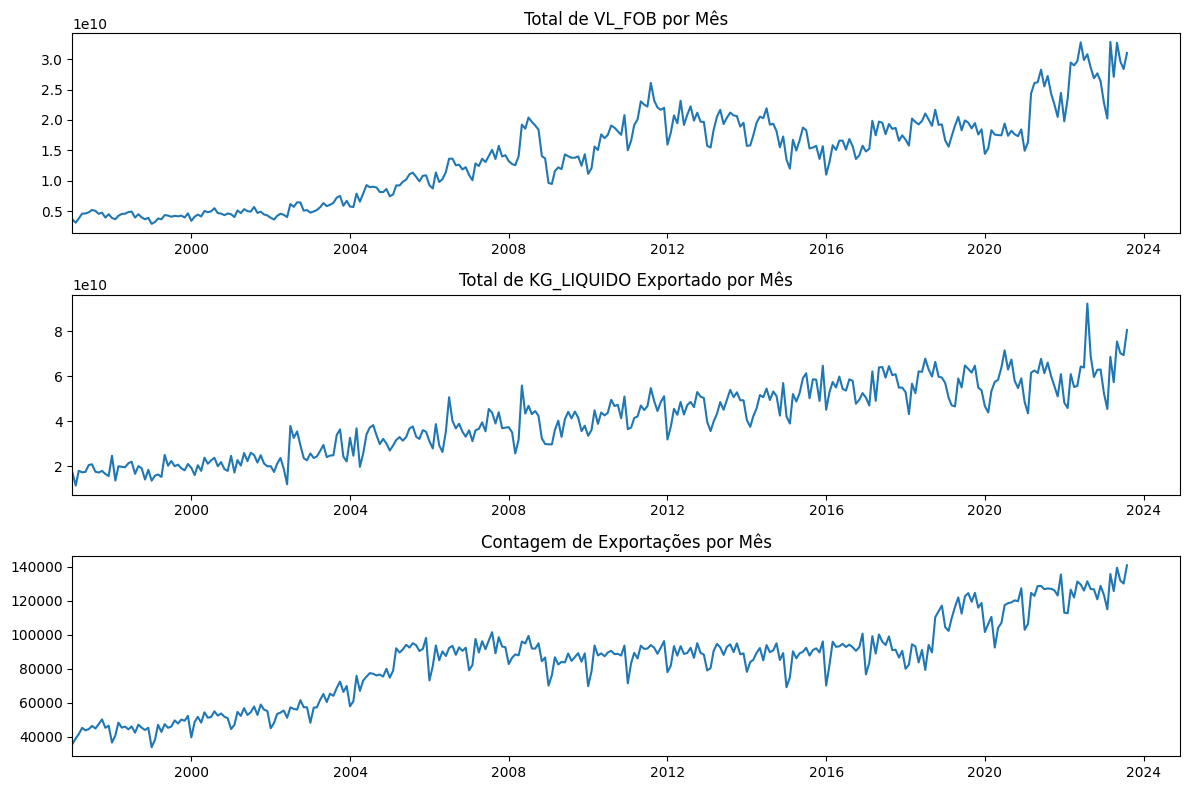

In [80]:
# Cria um plot de linha mostrando as exportações em ordem cronológica, contando o total de KG_LIQUIDO exportado por mês.
df_grouped_kg = df.groupby('DATA')['KG_LIQUIDO'].sum().reset_index()
# Cria um plot de linha mostrando as exportações em ordem cronológica, contando o total de VL_FOB exportado por mês.
df_grouped_vfob = df.groupby('DATA')['VL_FOB'].sum().reset_index()
# Cria um plot de linha mostrando as exportações em ordem cronológica, contando o total de linhas do dataframe, agrupado por mês.
df_grouped_count = df.groupby('DATA').size().reset_index(name='COUNT')

# Cria os subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].plot(df_grouped_vfob['DATA'], df_grouped_vfob['VL_FOB'])
axs[0].set_title('Total de VL_FOB por Mês')
axs[1].plot(df_grouped_kg['DATA'], df_grouped_kg['KG_LIQUIDO'])
axs[1].set_title('Total de KG_LIQUIDO Exportado por Mês')
axs[2].plot(df_grouped_count['DATA'], df_grouped_count['COUNT'])
axs[2].set_title('Contagem de Exportações por Mês')
# LIMITA OS EIXOS X PARA MELHOR VISUALIZAÇÃO ENTRE 1997 E 2024
for ax in axs:
    ax.set_xlim(pd.to_datetime('1997-01-01'), pd.to_datetime('2024-12-1'))

plt.tight_layout()
plt.show()

Abaixo será feito um plot dividindo o Total de exportações considerando o método de exportação

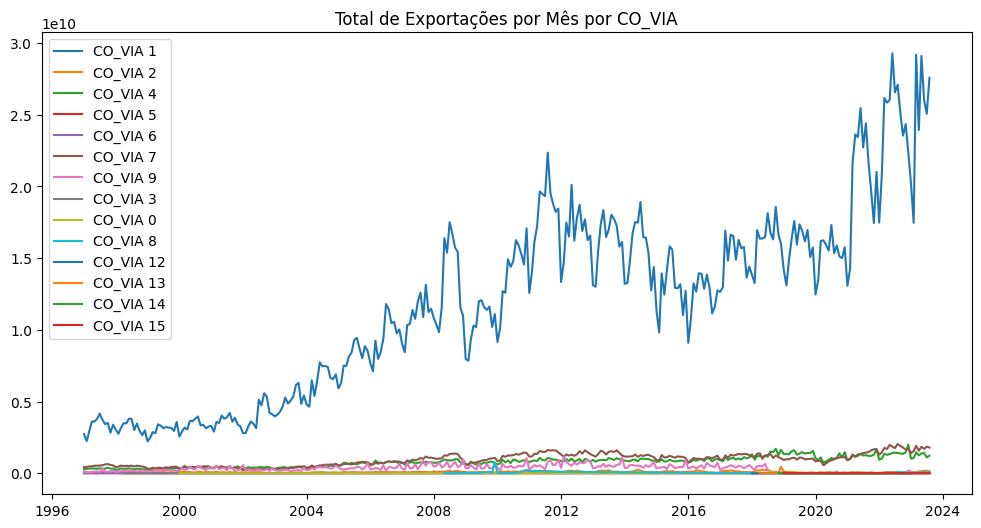

In [81]:
# Cria um plot de linha mostrando as exportações em ordem cronológica, contando o total de VL_FOB exportado por mês, mas agrupando por CO_VIA.
df_grouped_via = df.groupby(['DATA', 'CO_VIA'])['VL_FOB'].sum().reset_index()
plt.figure(figsize=(12,6))
for via in df_grouped_via['CO_VIA'].unique():
    subset = df_grouped_via[df_grouped_via['CO_VIA'] == via]
    plt.plot(subset['DATA'], subset['VL_FOB'], label=f'CO_VIA {via}')
plt.title('Total de Exportações por Mês por CO_VIA')
plt.legend()
plt.show()

Para esta análise, será considerado apenas as importações/exportações marítmas. Por esta razão será filtrado apenas `CO_VIA`=1

In [82]:
# Filtrar o df para obter apenas as linhas com CO_VIA igual a 1 (Marítima)
df_via_maritima = df[df['CO_VIA'] == 1]
df_via_maritima.head()

,CO_ANO,CO_MES,CO_PAIS,SG_UF_NCM,CO_VIA,KG_LIQUIDO,VL_FOB,DATA,NO_PAIS
2,1997,11,196,SP,1,3468,31510,1997-11-01,Costa Rica
4,1997,11,850,SP,1,117505,103866,1997-11-01,Venezuela
9,1997,11,355,RS,1,128,1476,1997-11-01,Hungria
13,1997,11,87,PR,1,573,5391,1997-11-01,Bélgica
19,1997,11,127,GO,1,1361,1980,1997-11-01,Cabo Verde


Aqui será realizado um novo plot para analisar a série temporal, quando se é filtrado apenas por importações/exportações marítmas

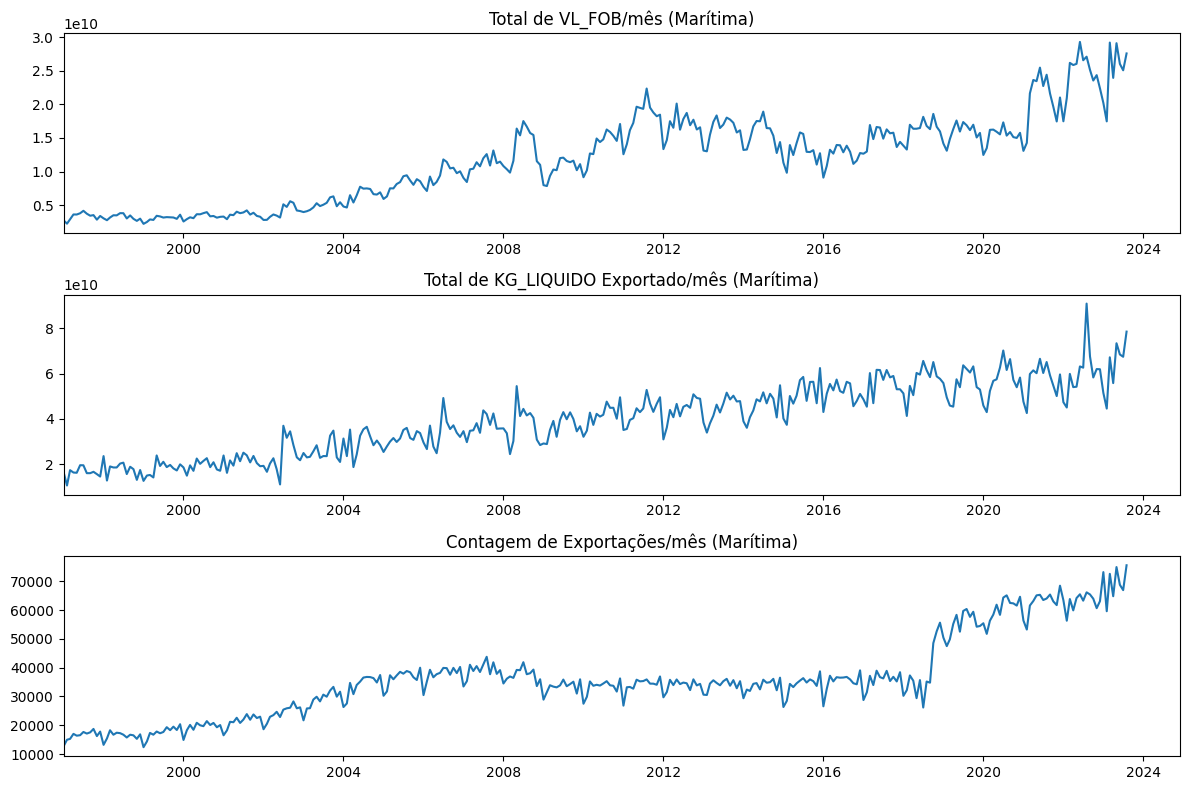

In [83]:
# Cria um plot de linha mostrando as exportações em ordem cronológica, contando o total de KG_LIQUIDO exportado por mês.
df_maritma_kg = df_via_maritima.groupby('DATA')['KG_LIQUIDO'].sum().reset_index()
# Cria um plot de linha mostrando as exportações em ordem cronológica, contando o total de VL_FOB exportado por mês.
df_maritma_vfob = df_via_maritima.groupby('DATA')['VL_FOB'].sum().reset_index()
# Cria um plot de linha mostrando as exportações em ordem cronológica, contando o total de linhas do dataframe, agrupado por mês.
df_maritma_count = df_via_maritima.groupby('DATA').size().reset_index(name='COUNT')

# Cria os subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].plot(df_maritma_vfob['DATA'], df_maritma_vfob['VL_FOB'])
axs[0].set_title('Total de VL_FOB/mês (Marítima)')
axs[1].plot(df_maritma_kg['DATA'], df_maritma_kg['KG_LIQUIDO'])
axs[1].set_title('Total de KG_LIQUIDO Exportado/mês (Marítima)')
axs[2].plot(df_maritma_count['DATA'], df_maritma_count['COUNT'])
axs[2].set_title('Contagem de Exportações/mês (Marítima)')

# LIMITA OS EIXOS X PARA MELHOR VISUALIZAÇÃO ENTRE 1997 E 2024
for ax in axs:
    ax.set_xlim(pd.to_datetime('1997-01-01'), pd.to_datetime('2024-12-1'))

plt.tight_layout()
plt.show()

In [84]:
df_maritma_kg.head()

,DATA,KG_LIQUIDO
0,1997-01-01,16501336974
1,1997-02-01,10575511709
2,1997-03-01,17356124372
3,1997-04-01,16312031706
4,1997-05-01,16206208200


## 5. Diferenciações e Autocorrelação

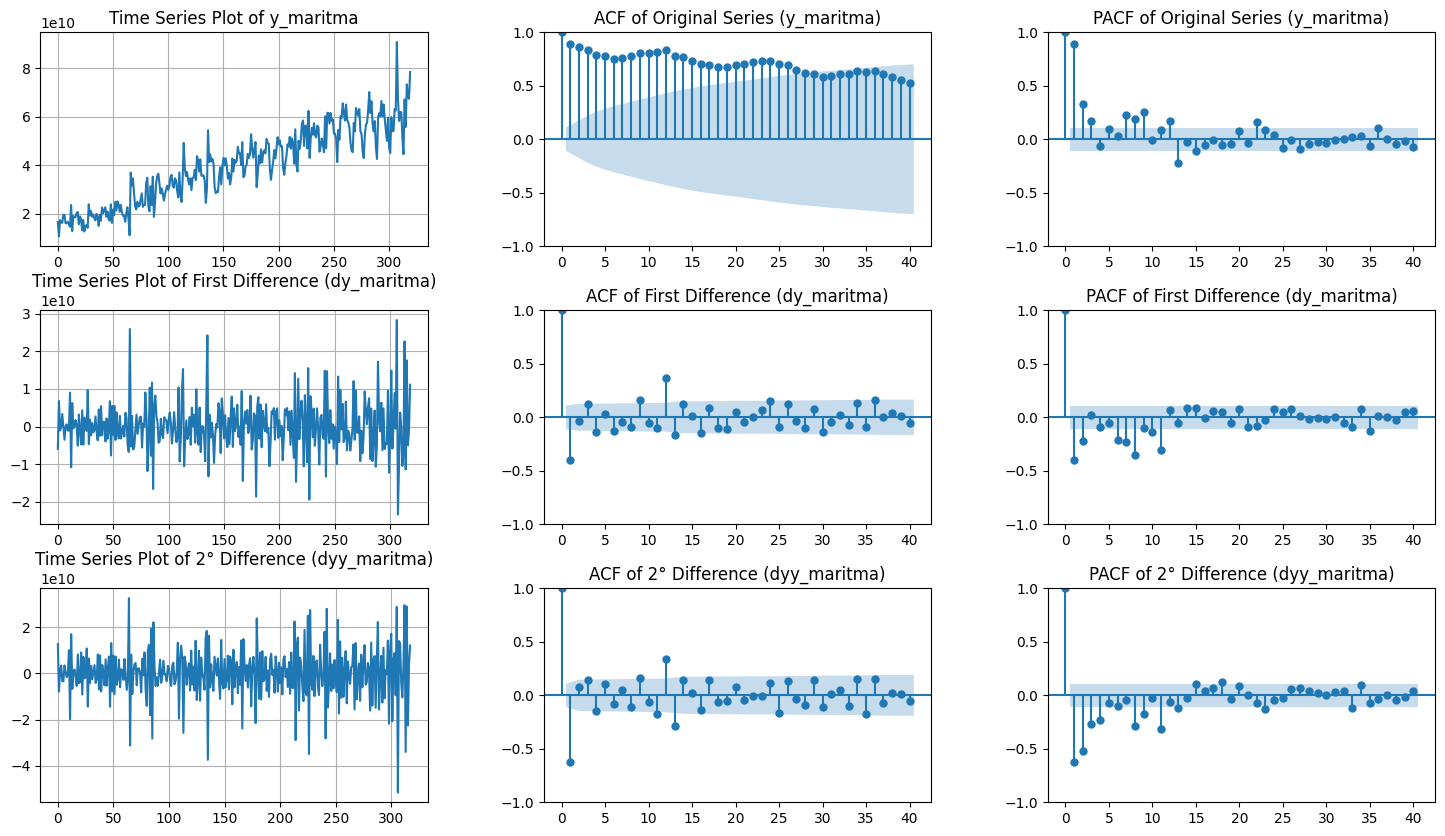

In [85]:
y_maritma = df_maritma_kg['KG_LIQUIDO']
dy_maritma = np.diff(df_maritma_kg['KG_LIQUIDO'])
dyy_maritma = np.diff(dy_maritma)

# Plotting using subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axes[0, 0].plot(y_maritma)
axes[0, 0].set_title('Time Series Plot of y_maritma')
axes[0, 0].grid(True)

# ACF Plot
plot_acf(y_maritma, lags=40, ax=axes[0, 1], title='ACF of Original Series (y_maritma)')

# PACF Plot
plot_pacf(y_maritma, lags=40, ax=axes[0, 2], title='PACF of Original Series (y_maritma)')

# Time Series Plot of Differenced Series
axes[1, 0].plot(dy_maritma)
axes[1, 0].set_title('Time Series Plot of First Difference (dy_maritma)')
axes[1, 0].grid(True)

# ACF Plot of Differenced Series
plot_acf(dy_maritma, lags=40, ax=axes[1, 1], title='ACF of First Difference (dy_maritma)')

# PACF Plot of Differenced Series
plot_pacf(dy_maritma, lags=40, ax=axes[1, 2], title='PACF of First Difference (dy_maritma)')

# Time Series Plot of 2° Differenced Series
axes[2, 0].plot(dyy_maritma)
axes[2, 0].set_title('Time Series Plot of 2° Difference (dyy_maritma)')
axes[2, 0].grid(True)

# ACF Plot of 2° Differenced Series
plot_acf(dyy_maritma, lags=40, ax=axes[2, 1], title='ACF of 2° Difference (dyy_maritma)')

# PACF Plot of 2° Differenced Series
plot_pacf(dyy_maritma, lags=40, ax=axes[2, 2], title='PACF of 2° Difference (dyy_maritma)')

plt.show()

## 6. Teste ADF para Diferenciação

In [86]:
# Teste ADF
k_calculado = np.floor((len(dy_maritma) - 1)**(1/3)).astype(int)

resultado_adf = adfuller(
    dy_maritma,
    maxlag=k_calculado,
    autolag=None, # Desativa a seleção automática do k
    regression='c' # Padrão para testar estacionariedade
)

print("=== Resultados do Teste Aumentado de Dickey-Fuller (ADF) ===")
print(f"Estatística de Teste ADF: {resultado_adf[0]:.4f}")
print(f"Valor p (P-value): {resultado_adf[1]:.4f}")
print(f"Número de Defasagens (Lags): {resultado_adf[2]}")
print("Valores Críticos:")
for key, value in resultado_adf[4].items():
    print(f"  {key}: {value:.4f}")

=== Resultados do Teste Aumentado de Dickey-Fuller (ADF) ===
Estatística de Teste ADF: -11.8304
Valor p (P-value): 0.0000
Número de Defasagens (Lags): 6
Valores Críticos:
  1%: -3.4515
  5%: -2.8708
  10%: -2.5717


**Interpretação do Teste ADF**

* **Estatística ADF:** –11.8304
* **p-value:** 0.0000
* **Lags:** 6
* **Valores críticos:**
  * 1%: –3.4515
  * 5%: –2.8708
  * 10%: –2.5717

1° comparação da estatística ADF com os valores críticos: Estatística ADF **menor (mais negativa)** que o valor crítico → rejeita H0 (a série é estacionária). –11.8304 é **muito mais negativo** que todos os valores críticos. Isso já indica que **rejeitamos fortemente a hipótese nula de raiz unitária**.

2° Interpretação do p-value: **p-value = 0.0000** → extremamente baixo. Muito menor que 1%, 5% ou 10%.

Isso confirma que **rejeitamos H0 com altíssima confiança**.

## 7. Estimando através do ARIMA Ljung Box

In [87]:
## 1. Model estimation
model = ARIMA(endog=y_maritma, order=(1, 1, 1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             KG_LIQUIDO   No. Observations:                  320
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7627.428
Date:                Sun, 16 Nov 2025   AIC                          15260.857
Time:                        21:34:40   BIC                          15272.152
Sample:                             0   HQIC                         15265.368
                                - 320                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3256      0.068      4.817      0.000       0.193       0.458
ma.L1         -0.8979      0.040    -22.678      0.000      -0.975      -0.820
sigma2      3.797e+19        nan        nan        n

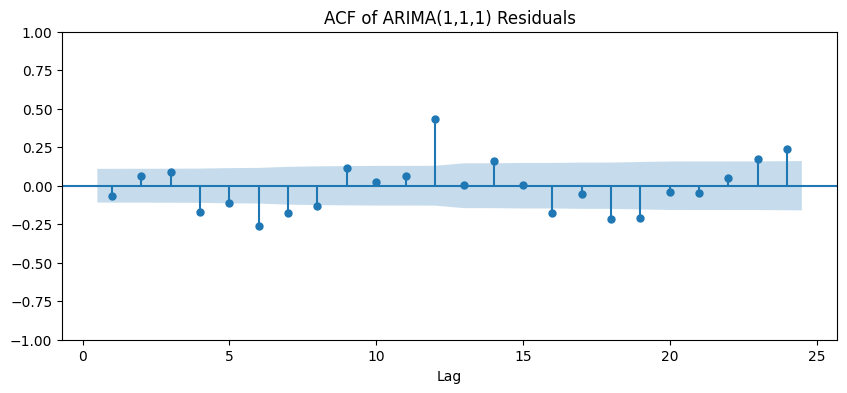


--- Ljung-Box Test (Q-Test) Results ---

Ljung-Box Test (Lags=24, Model DF=2 (MA1 + Constant)):
       lb_stat     lb_pvalue
24  210.497171  9.917672e-33


In [88]:
## 2. Model diagnostic

res = results.resid

# Python: Plot the Autocorrelation Function (ACF) of the residuals
# We use lags=24 to align with the Ljung-Box test below.
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(res, lags=24, zero=False, ax=ax, title='ACF of ARIMA(1,1,1) Residuals')
ax.set_xlabel('Lag')
plt.show()

## 3. R: Box.test(res, lag=24, fitdf=4, type="Ljung")

print("\n--- Ljung-Box Test (Q-Test) Results ---")

# Calculate for Ljung-Box up to 24 lags, compensating for 2 estimated parameters (MA1 and Constant)
# The degrees of freedom for the Q-statistic is lags - model_df. (24 - 2 = 22)
lb_test_results_df = acorr_ljungbox(res, lags=[24], model_df=2, return_df=True)
print("\nLjung-Box Test (Lags=24, Model DF=2 (MA1 + Constant)):")
print(lb_test_results_df)

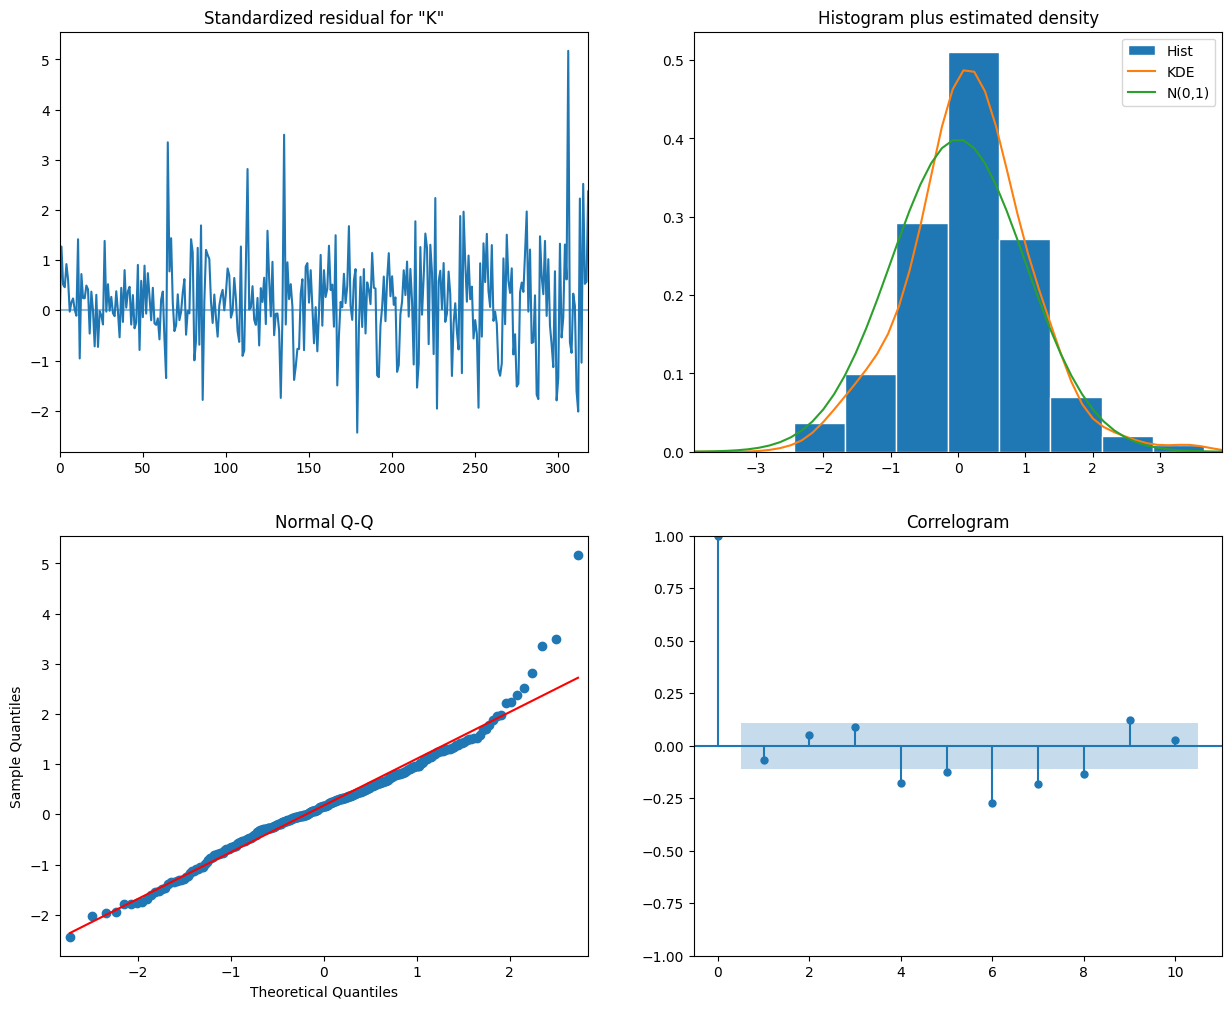

In [89]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

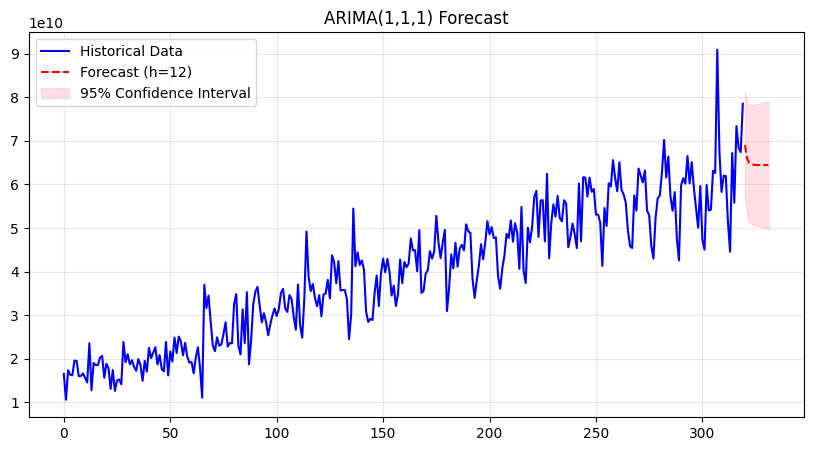

In [90]:
## 3. Model prediction

# Generate forecast for 12 steps ahead (h=12)
forecast_results = results.get_forecast(steps=12)

# Extract predictions and confidence intervals
mean_forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(y_maritma, label='Historical Data', color='blue')
plt.plot(mean_forecast, label='Forecast (h=12)', color='red', linestyle='--')
plt.fill_between(mean_forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('ARIMA(1,1,1) Forecast')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Verificando estimativa pelo Autoarima (StatsForecast)

In [91]:
# Create a DataFrame from the 'y_maritma'
data = pd.DataFrame({
    'unique_id': 'y_maritma',  # A unique identifier for our single series
    'ds': range(len(y_maritma)),      # Using integers as time steps
    'y': y_maritma                    # The time series values
})

# Initializate StatsForecast
sf = StatsForecast(
    models=[AutoARIMA()],
    freq=1 # Frequency of the data (1 for no specific frequency, or hourly, daily etc.)
)

# Fit the model to the data
sf.fit(data)

# Get the results
forecast_df = sf.predict(h=12) # Forecast 12 steps ahead
print("\nForecast:")
print(forecast_df)

# Model


Forecast:
    unique_id   ds     AutoARIMA
0   y_maritma  320  6.920424e+10
1   y_maritma  321  6.650905e+10
2   y_maritma  322  6.582749e+10
3   y_maritma  323  6.575639e+10
4   y_maritma  324  6.587036e+10
5   y_maritma  325  6.604044e+10
6   y_maritma  326  6.622752e+10
7   y_maritma  327  6.641977e+10
8   y_maritma  328  6.661357e+10
9   y_maritma  329  6.680784e+10
10  y_maritma  330  6.700227e+10
11  y_maritma  331  6.719673e+10


In [92]:
fitted_autoarima_model = sf.fitted_[0][0].model_
arima_string(fitted_autoarima_model)

'ARIMA(1,1,1) with drift        '

Percebe-se que o AutoARIMA escolheu parâmetros iguais aos estimados utilizando o método Ljung-Box.

In [118]:
# Create a DataFrame from the 'y_maritma'
data2 = pd.DataFrame({
    'unique_id': 'y_maritma',  # A unique identifier for our single series
    'ds': range(len(y_maritma)-12),      # Using integers as time steps
    'y': y_maritma[:len(y_maritma)-12]                    # The time series values
})

# Initializate StatsForecast
sf2 = StatsForecast(
    models=[AutoARIMA()],
    freq=1 # Frequency of the data (1 for no specific frequency, or hourly, daily etc.)
)

# Fit the model to the data
sf2.fit(data2)

# Get the results
forecast_df2 = sf2.predict(h=12) # Forecast 12 steps ahead
print("\nForecast:")
print(forecast_df2)


Forecast:
    unique_id   ds     AutoARIMA
0   y_maritma  308  7.294240e+10
1   y_maritma  309  6.709785e+10
2   y_maritma  310  6.530624e+10
3   y_maritma  311  6.486896e+10
4   y_maritma  312  6.488424e+10
5   y_maritma  313  6.505073e+10
6   y_maritma  314  6.526777e+10
7   y_maritma  315  6.550168e+10
8   y_maritma  316  6.574125e+10
9   y_maritma  317  6.598269e+10
10  y_maritma  318  6.622477e+10
11  y_maritma  319  6.646705e+10


## 9. Decomposição da série temporal

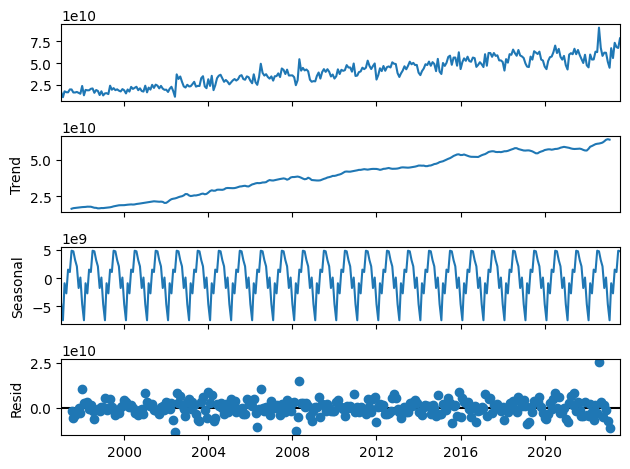

In [93]:
MARIT_AD = pd.Series(df_maritma_kg["KG_LIQUIDO"].values,
               index=pd.date_range(start="1997-01-01",
               periods=len(df_maritma_kg), freq="MS"))
# Decomposição Sazonal
decompose_marit_ad = seasonal_decompose(
  MARIT_AD,
  model="additive", #alt: multiplicative
  period=12)

decompose_marit_ad.plot()

# Exibir o gráfico
plt.show()

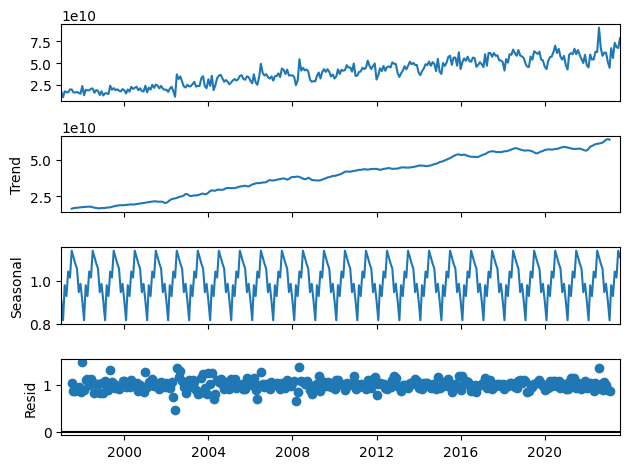

In [94]:
MARIT_MULT = pd.Series(df_maritma_kg["KG_LIQUIDO"].values,
               index=pd.date_range(start="1997-01-01",
               periods=len(df_maritma_kg), freq="MS"))

# Decomposição Sazonal
decompose_marit_mult = seasonal_decompose(
  MARIT_MULT,
  model="multiplicative",
  period=12)

decompose_marit_mult.plot()

# Exibir o gráfico
plt.show()

## 10. Decomposição temporal com Prophet

In [95]:
# Transform dataset to Prophet
df_marit_prophet=df_maritma_kg 
df_marit_prophet.columns= ['ds', 'y']
df_marit_prophet.head()

,ds,y
0,1997-01-01,16501336974
1,1997-02-01,10575511709
2,1997-03-01,17356124372
3,1997-04-01,16312031706
4,1997-05-01,16206208200


In [96]:
# get index for training dataset
idx = df_marit_prophet.shape[0]-12
df_train = df_marit_prophet.iloc[:idx]
df_test = df_marit_prophet.iloc[idx:]

In [97]:
# Prophet using default values
m = Prophet()
m.fit(df_train)

21:34:43 - cmdstanpy - INFO - Chain [1] start processing
21:34:43 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
# make future dataframe
future = m.make_future_dataframe(periods=12, freq='MS')

In [99]:
# predict method
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
315,2023-04-01,5.981214e+10,5.416048e+10,6.519274e+10
316,2023-05-01,6.331057e+10,5.773189e+10,6.885774e+10
317,2023-06-01,6.297661e+10,5.708480e+10,6.843267e+10
318,2023-07-01,6.793141e+10,6.235759e+10,7.340474e+10
319,2023-08-01,6.707422e+10,6.139901e+10,7.296597e+10


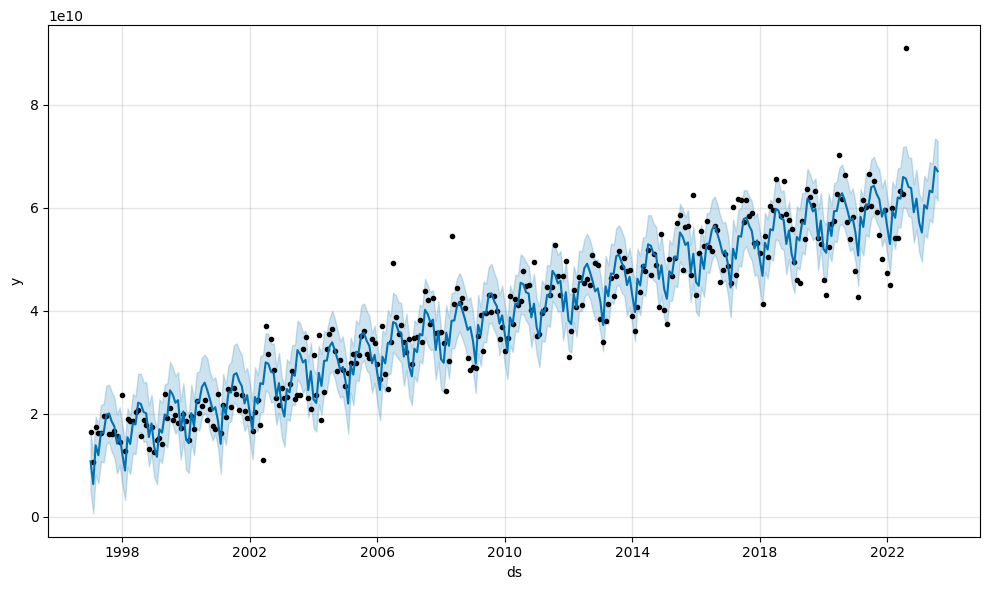

In [100]:
fig1 = m.plot(forecast)

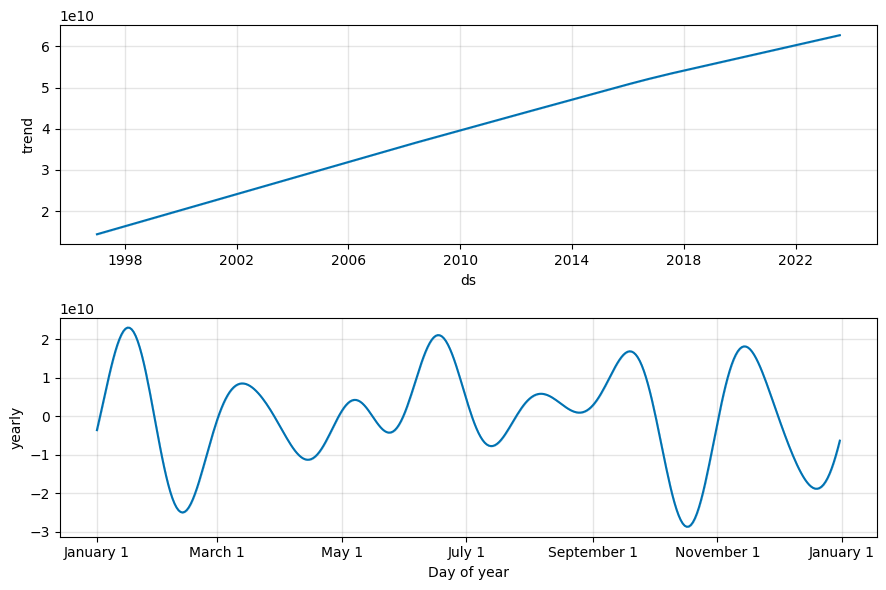

In [101]:
fig2 = m.plot_components(forecast)

In [102]:
# RMSE Prophet w/ default values

y_true = df_test['y']
y_pred_prophet_add = forecast.iloc[idx:]['yhat']
np.sqrt(mean_squared_error(y_true, y_pred_prophet_add))

6584549487.91917

In [103]:
## improving fit with multiplicative seasonality

# fit method
m2 = Prophet(seasonality_mode='multiplicative')
m2.fit(df_train)

# make future dataframe: note to specify frequency here
future = m2.make_future_dataframe(periods=12, freq='MS')

# predict method
forecast2 = m2.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

21:34:45 - cmdstanpy - INFO - Chain [1] start processing
21:34:45 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
315,2023-04-01,5.750709e+10,5.193026e+10,6.314276e+10
316,2023-05-01,6.349561e+10,5.826875e+10,6.887008e+10
317,2023-06-01,6.392759e+10,5.852650e+10,6.907052e+10
318,2023-07-01,7.016426e+10,6.508420e+10,7.522827e+10
319,2023-08-01,7.048184e+10,6.536582e+10,7.632279e+10


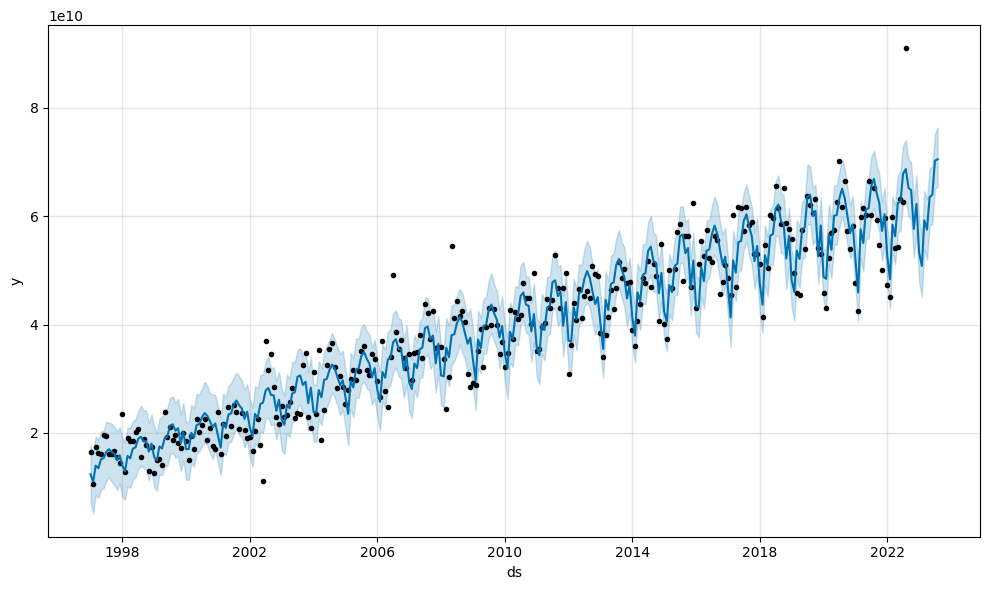

In [104]:
fig3 = m2.plot(forecast2)

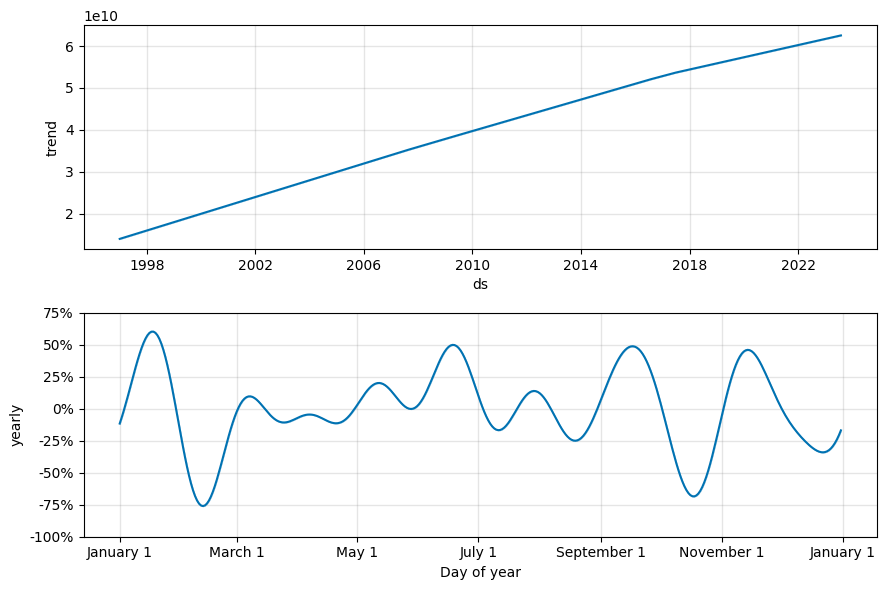

In [105]:
# components
fig4 = m2.plot_components(forecast2)

In [106]:
y_pred_prophet_mult= forecast2.iloc[idx:]['yhat']
np.sqrt(mean_squared_error(y_true, y_pred_prophet_mult))

5527396780.594824

## 11. Modelo SARIMA

In [107]:
## SARIMA: vamos usar o Auto Arima para detectar as ordens

models = [AutoARIMA(season_length=12)]
sf = StatsForecast(models=models, freq='MS')
df = df_train.copy()
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
sf.fit(df)

StatsForecast(models=[AutoARIMA])

In [108]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(1,1,1)(0,0,2)[12] with drift        '

In [109]:
# Testando vários modelos SARIMA e comparando AIC
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelos = {}

# Modelo 1
mod1 = SARIMAX(y_maritma, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
modelos["SARIMA(1,1,1)(1,1,1,12)"] = mod1.aic

# Modelo 2
mod2 = SARIMAX(y_maritma, order=(1,1,1), seasonal_order=(0,1,1,12)).fit()
modelos["SARIMA(1,1,1)(0,1,1,12)"] = mod2.aic

# Modelo 3
mod3 = SARIMAX(y_maritma, order=(1,1,1), seasonal_order=(0,0,1,12)).fit()
modelos["SARIMA(1,1,1)(0,0,1,12)"] = mod3.aic

# Modelo 4
mod4 = SARIMAX(y_maritma, order=(1,1,1), seasonal_order=(0,0,2,12)).fit()
modelos["SARIMA(1,1,1)(0,0,2,12)"] = mod4.aic

# Modelo 5
mod5 = SARIMAX(y_maritma, order=(1,1,1), seasonal_order=(0,1,2,12)).fit()
modelos["SARIMA(1,1,1)(0,1,2,12)"] = mod5.aic

# Modelo 6
mod6 = SARIMAX(y_maritma, order=(1,1,1), seasonal_order=(1,1,2,12)).fit()
modelos["SARIMA(1,1,1)(1,1,2,12)"] = mod6.aic

# Mostrar ranking
pd.DataFrame(modelos.items(), columns=["Modelo", "AIC"]).sort_values("AIC")

,Modelo,AIC
4,"SARIMA(1,1,1)(0,1,2,12)",14617.837495
1,"SARIMA(1,1,1)(0,1,1,12)",14618.167472
0,"SARIMA(1,1,1)(1,1,1,12)",14618.308135
5,"SARIMA(1,1,1)(1,1,2,12)",14618.789707
3,"SARIMA(1,1,1)(0,0,2,12)",15205.616972
2,"SARIMA(1,1,1)(0,0,1,12)",15212.181466


c:\Users\ericl\Downloads\projeto_intermediario_FA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  308
Model:             ARIMA(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -7016.620
Date:                               Sun, 16 Nov 2025   AIC                          14043.241
Time:                                       21:35:05   BIC                          14061.676
Sample:                                   01-01-1997   HQIC                         14050.622
                                        - 08-01-2022                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1766      0.124      1.429      0.153      -0.066       0.419
ma.L1      

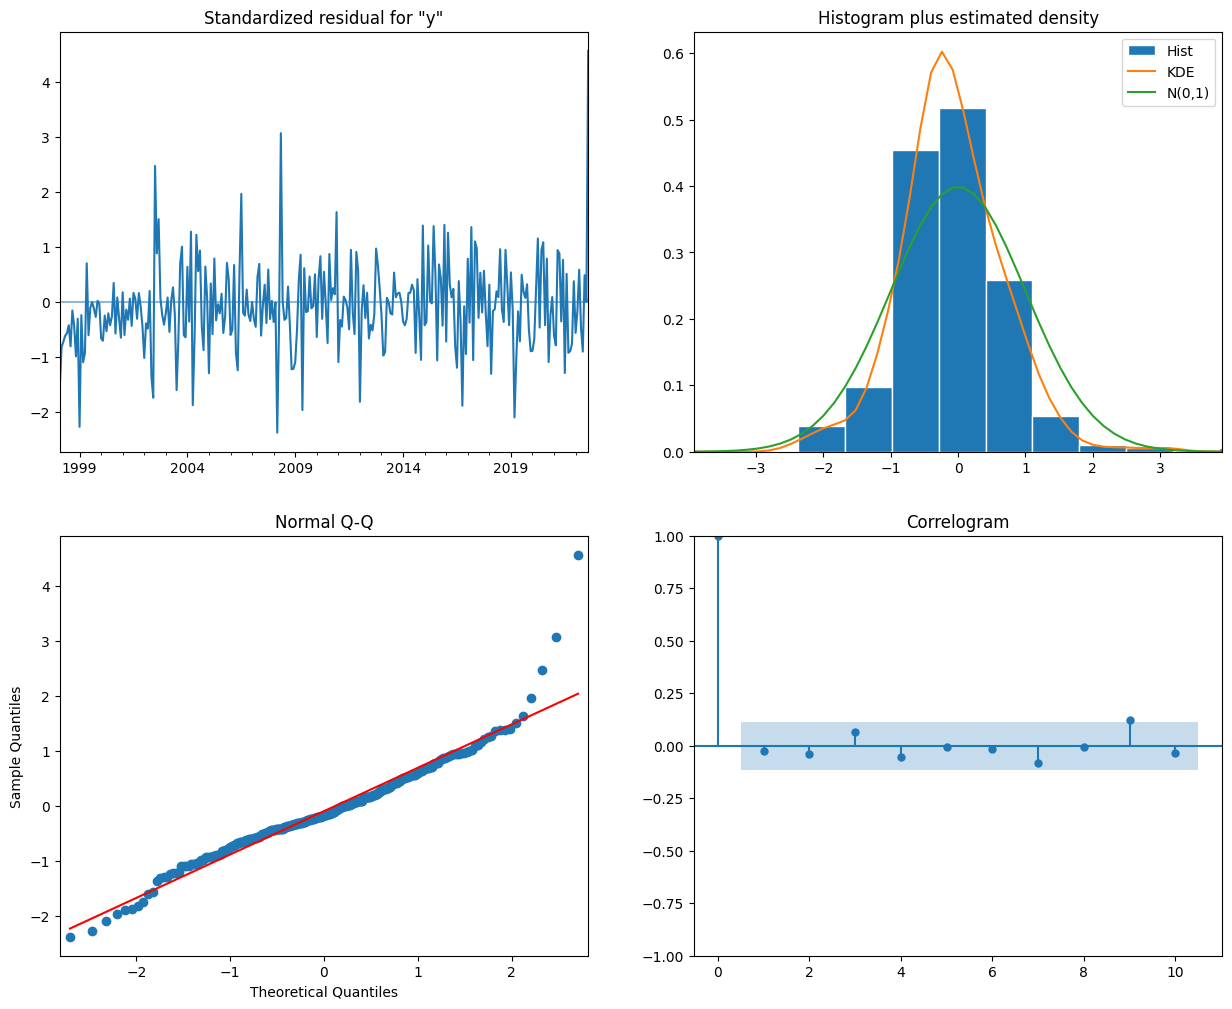

In [110]:
## summary of auto model

# fit model
model = ARIMA(endog=df_train.set_index('ds'), order=(1,1,1), seasonal_order=(0,1,2,12), freq='MS')
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [111]:
forecast_results_sarima = model_fit.get_forecast(steps=12)
forecast_results_sarima.predicted_mean

2022-09-01    6.934409e+10
2022-10-01    6.386993e+10
2022-11-01    5.840193e+10
2022-12-01    6.328683e+10
2023-01-01    5.441548e+10
2023-02-01    5.150759e+10
2023-03-01    6.199458e+10
2023-04-01    5.938901e+10
2023-05-01    6.302326e+10
2023-06-01    6.650711e+10
2023-07-01    6.826312e+10
2023-08-01    7.686000e+10
Freq: MS, Name: predicted_mean, dtype: float64

In [112]:
# RMSE SARIMA: best model

y_true = df_test['y']
y_pred = forecast_results_sarima.predicted_mean.values
np.sqrt(mean_squared_error(y_true, y_pred))

4662896242.09317

## 12. Respostas

### 12.1. Plote os gráficos da série e das ACF/PACF e discorra sobre o aspecto da série. Faça o teste de raíz unitária e explique as conclusões. Existe tendência estocástica?

- **A série (`y_maritma`)** mostra uma tendência crescente bem acentuada, indicando não estacionariedade, ou seja, a média e a variância mudam ao longo do tempo. Isso é confirmado visualmente e também pela ACF e PACF originais. **A ACF** Decai lentamente, sem cortar abruptamente. Isso é típico de uma série não estacionária. **A PACF** tem um pico muito forte no lag 1 e depois decai. Isso sugere que há componente AR (autoregressiva) no processo.

- A **primeira diferença (`dy_maritma`)** parece oscilar em torno de uma média constante, o que indica que a estacionariedade foi alcançada. Isso mostra que **d = 1** é provavelmente o valor adequado. Contudo, percebe-se alguns picos com significado estatístico, apesar de não apresentarem um comportamento com tendências visíveis. **A ACF** cai rapidamente para zero após o lag 1 ou 2. Isso sugere a presença de um termo MA(1). **A PACF** também tem um grande pico no lag 1 e depois se estabiliza. Isso indicar a possibilidade de um termo AR(1).

- A **segunda diferença (`ddy_maritma`)** tende a mostrar maiores oscilações e, no respectivo ACF/PACF, aparecem sinais de autocorrelações negativas em lag1 (uma possibilidade é indicar que há over-differencing). Provavelmente não é necessário diferenciar 2 graus, pois pode introduz padrões artificiais e torna o ruído mais complicado.

- **Interpretação do Teste ADF**: 1° a Estatística ADF é menor (mais negativa) que o valor crítico. Rejeita-se H0 (a série é estacionária). –11.8304 é **muito mais negativo** que todos os valores críticos. Isso já indica que rejeitamos fortemente a hipótese nula de raiz unitária. 2° Interpretação do p-value: p-value = 0.0000 é extremamente baixo. Muito menor que 1%, 5% ou 10%. Isso confirma que **rejeitamos H0 com altíssima confiança**.

    - Estatística ADF: –11.8304
    - p-value:** 0.0000
    - Lags: 6
    - Valores críticos: 1%: –3.4515; 5%: –2.8708; 10%: –2.5717

### 12.2. Use um método de decomposição estudado e explique os componentes, tendo em vista o aspecto da série. Existe sazonalidade? Qual periodicidade?

- Segundo o grafico da serie temporal ja podemos observar uma sazonalidade acentuada  por todo periodo analisado segundo o grafico abaixo referenciado no topico 9. No caso temos uma sazonialidade com corpotamento anual que em si possui similararidade com o corpotamento real da base de dados escolhida. Existem 27 anos nesta base de dados, e a componente sasonal identificada também reconhece 27 períodos cíclicos, conferindo um comportamento anual.

- Utilizando o Prophet, também indentificamos padrões sazonais em dieferentes épocas de cada ano. Por se tratar de uma base extrimamente braisleira podemos observar nesses padrões epocas do ano que concentram datas festivas e momentos de maior demanda ou "necessidade de estoque" como por exemplo o pico entre dezembro e janeiro e o declinio entre janeiro e março devido a epoca de carnaval onde o preparo para data ocorre em meses anteriores dando enfase ao comportamento que observamos sazonal no grafico abaixo dop prophet.

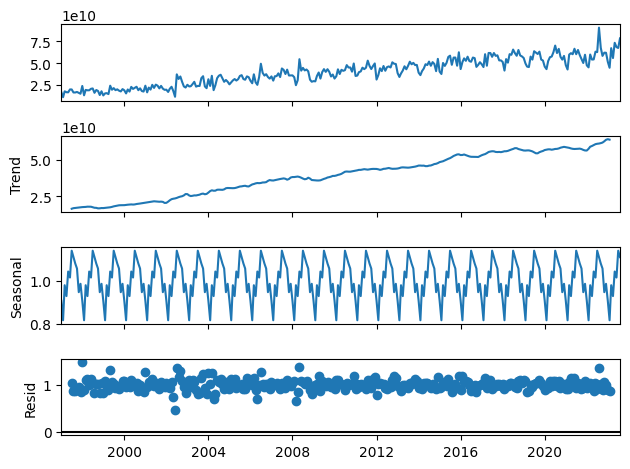

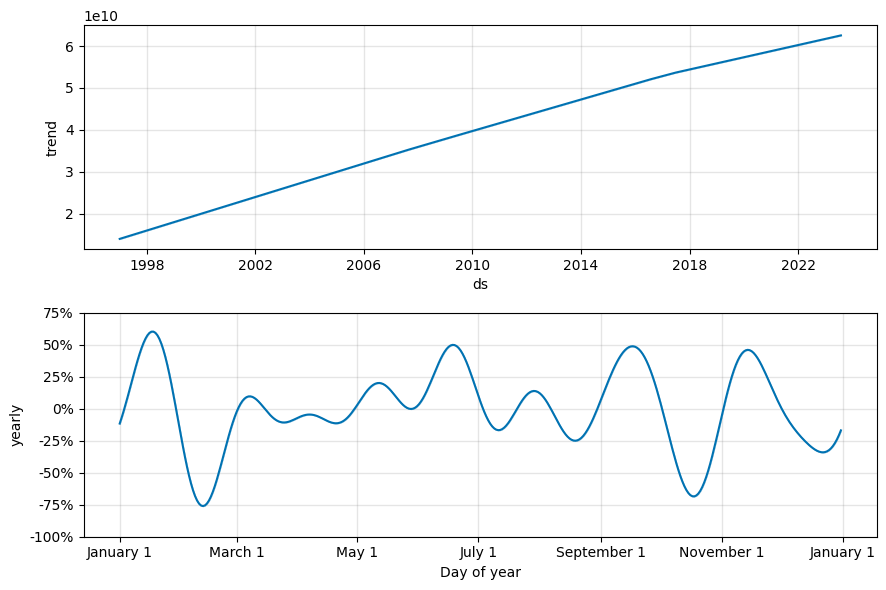

### 12.3. Identifique um modelo SARIMA apropriado. Justifique o modelo escolhido através de critérios de informação e/ou usando a etapa de identificação da abordagem Box-Jenkins. Nesta etapa é possível utilizar um método automático de seleção das ordens do modelo.

- Através da biblioteca Autoarima, foi possível estimar um SARIMA(1,1,1)(0,0,2)[12] como mais indicado para a série temporal em questão. Contudo, ao comparar o teste AIC de diversos modelos SARIMA, o melhor resultado foi o modelo **SARIMA(1,1,1)(0,1,2,12)**. Esse modelo também resultou em um menor RMSE.

- Analisando graficamente as diferenciações feitas no tópico 5, pode-se confirmar que a série fica estacionária após 1 diferenciação. Contudo, há alguns lags com correlação que representam algum grau de significado estatístico. Observa-se isso claramente no lag 12 do ACF. Isso pode indicar que um Sarima com P=1 pode representar bem o modelo, e, como ainda há um lag defasado vom significância estatística, uma diferenciação sazonal também é bem-vinda D=1. Já o Q é difícil estimar visualmente, sem o auxílio da ferramenta automática.

### 12.4. Faça a verificação de diagnóstico residual de seu modelo ARIMA. Os resíduos são ruído branco?

- Conseguimos atingir um comportamento residual que gira em torno de zero o que sugere um ruido branco. Isso é confirmado pelo histograma na figura abaixo, resgatada do tópico 7, monstrando que variância gira em torno do zero, de forma simétrica, sem tendência aparente;

- Podemos confirmar o comportamento de ruído branco dos resíduos observando o gráfico QQ plot, em que se perce que os valores reais e os valores porjetados apresentam um comportamento muito próximo um do outro, acompanhando a diagonal, sem enviesar para algum dos lados e não possui o típico formato em S, indesejado. Isso reforça a hipótese de que os residuos são um ruido branco.

- Em relação ao correlograma percebe-se que os valores estão abaixo de uma margem significancia estatística contudo percebe-se uma componente sazonal que poderia ser observada melhor em um modelo prophet ou SARIMA, que modele a sazonalidade.

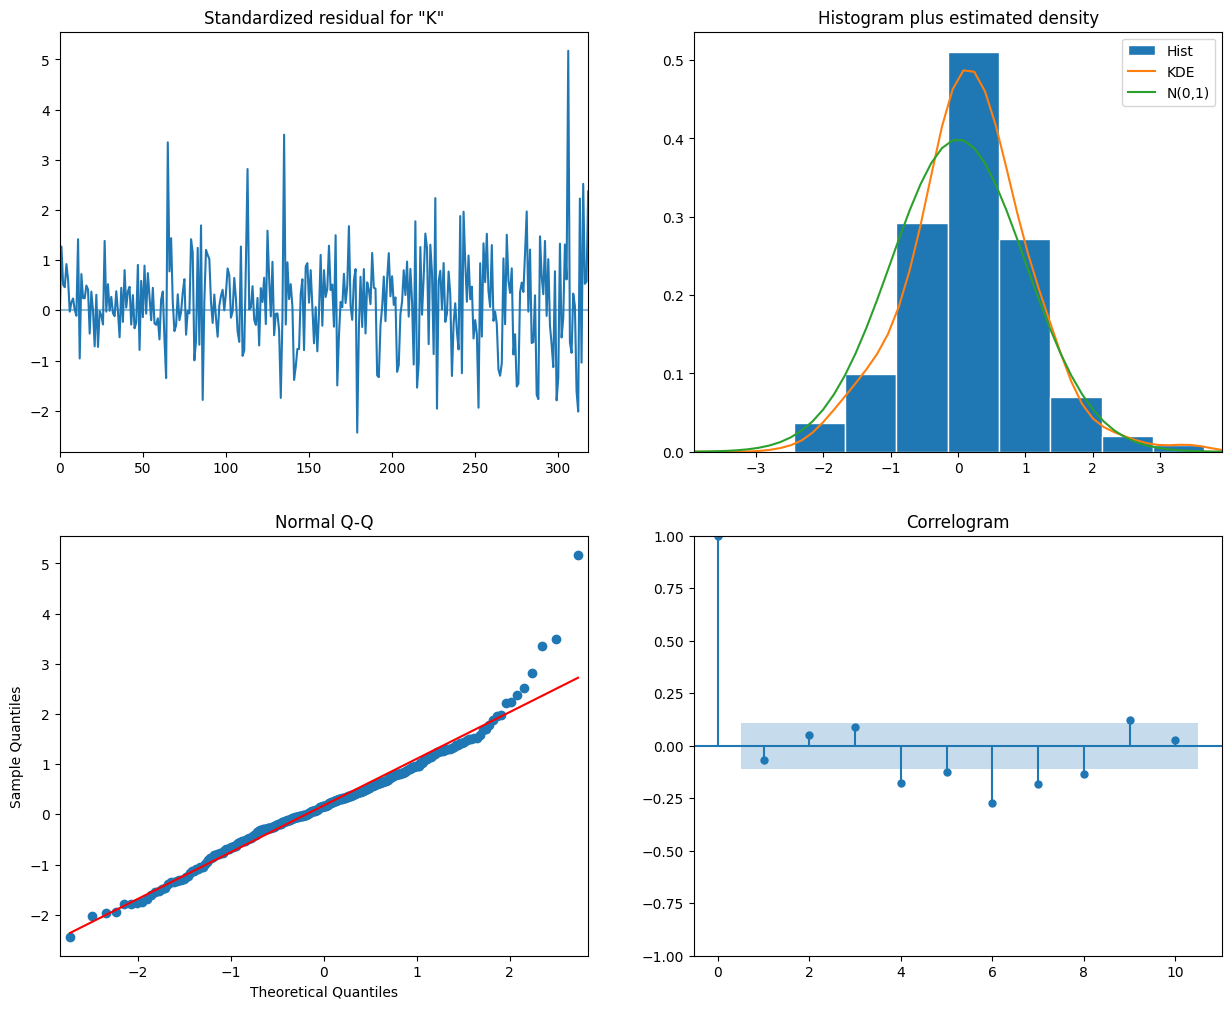

### 12.5. Use o modelo SARIMA de sua escolha para fazer previsões h (livre escolha) passos à frente.

In [127]:
df_fim = pd.DataFrame({
    'idx': forecast_results_sarima.predicted_mean.index,
    'real': y_true.values,
    'Prophet_Add': y_pred_prophet_add.values,
    'Prophet_Mult': y_pred_prophet_mult.values,
    'SARIMA': forecast_results_sarima.predicted_mean.values,
    'AutoARIMA': forecast_df2["AutoARIMA"].values
})

df_fim

,idx,real,Prophet_Add,Prophet_Mult,SARIMA,AutoARIMA
0,2022-09-01,67578953127,6.404587e+10,6.519504e+10,6.934409e+10,7.294240e+10
1,2022-10-01,58288869852,6.378955e+10,6.477800e+10,6.386993e+10,6.709785e+10
2,2022-11-01,61997912860,5.912599e+10,5.762607e+10,5.840193e+10,6.530624e+10
3,2022-12-01,61923722557,6.174272e+10,6.225055e+10,6.328683e+10,6.486896e+10
4,2023-01-01,51477014796,5.714489e+10,5.320199e+10,5.441548e+10,6.488424e+10
5,2023-02-01,44553884881,5.517805e+10,5.078963e+10,5.150759e+10,6.505073e+10
6,2023-03-01,67189968878,6.050445e+10,5.919808e+10,6.199458e+10,6.526777e+10
7,2023-04-01,55806513864,5.981214e+10,5.750709e+10,5.938901e+10,6.550168e+10
8,2023-05-01,73405254394,6.331057e+10,6.349561e+10,6.302326e+10,6.574125e+10
9,2023-06-01,68441519368,6.297661e+10,6.392759e+10,6.650711e+10,6.598269e+10


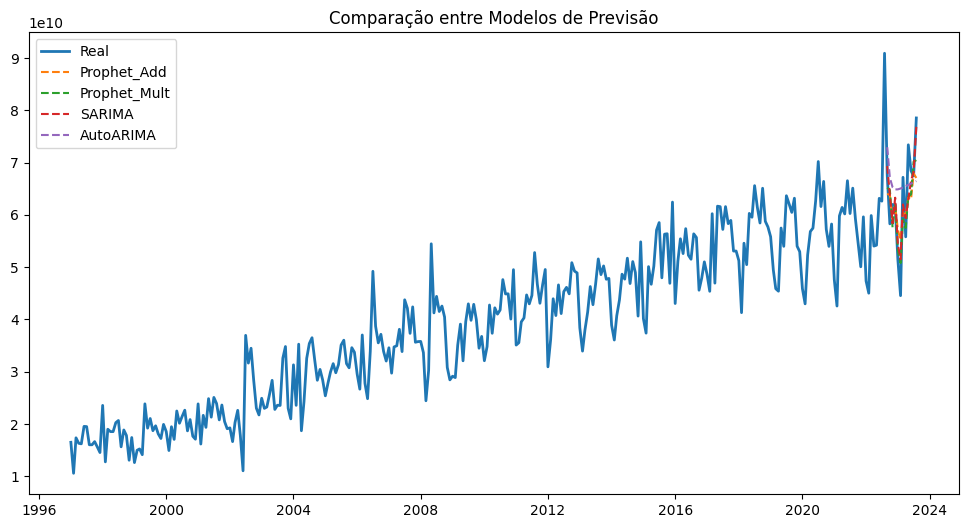

In [149]:
df_fim2=df_fim.drop("real", axis=1)
plt.figure(figsize=(12,6))
plt.plot(df_maritma_kg["ds"],df_maritma_kg["y"], label='Real', linewidth=2)

for col in df_fim2.columns[1:]:
    plt.plot(df_fim2['idx'],df_fim2[col], label=col, linestyle='--')
plt.title('Comparação entre Modelos de Previsão')    
plt.legend()
plt.show()

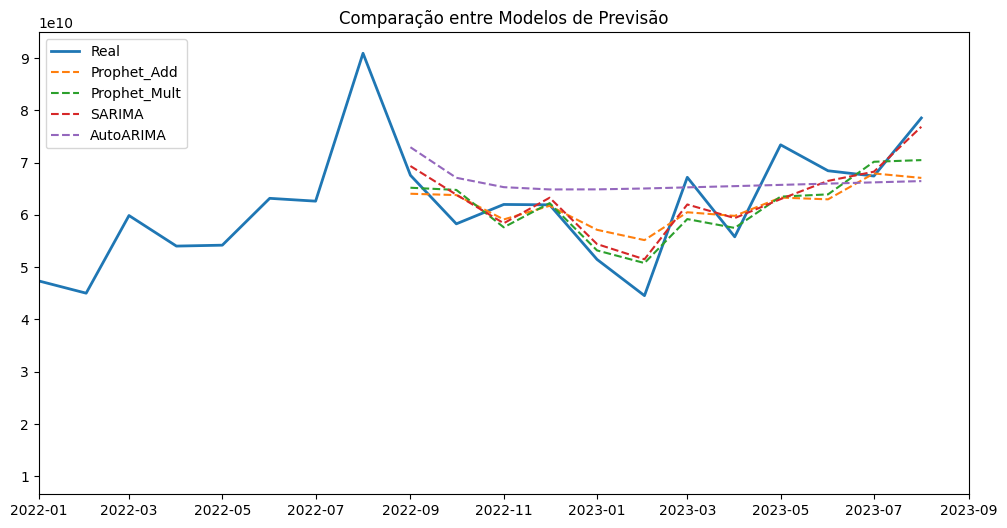

In [150]:
plt.figure(figsize=(12,6))
plt.plot(df_maritma_kg["ds"],df_maritma_kg["y"], label='Real', linewidth=2)

for col in df_fim2.columns[1:]:
    plt.plot(df_fim2['idx'],df_fim2[col], label=col, linestyle='--')

# criando um recorte apenas após 2022 para melhor visualização
plt.xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2023-9-1'))
plt.title('Comparação entre Modelos de Previsão')

plt.legend()
plt.show()

In [151]:
rmse_dict = {}
for col in df_fim.columns[1:]:
    rmse = np.sqrt(mean_squared_error(df_fim['real'], df_fim[col]))
    rmse_dict[col] = rmse

rmse_dict

{'real': 0.0,
 'Prophet_Add': 6584549487.91917,
 'Prophet_Mult': 5527396780.594824,
 'SARIMA': 4662896242.09317,
 'AutoARIMA': 9289727680.988777}

Com base nas previsões simuladas pelos modelos Prophet (aditivo e multiplicativo), SARIMA e o próprio ARIMA, percebe-se um melhor desempenho no SARIMA. Importante destacar que para fazer esse cálculo, foi realizado um rolling-back de 12 meses, para prever valores dos últimos 12 valores que a série temporal trabalhada já possui, e assim compará-los para obter o RMSE de cada modelo preditivo em questão.